In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

from dotenv import load_dotenv
from nixtla import NixtlaClient

warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

In [2]:
plt.rcParams['figure.figsize'] = (9,6)

In [3]:
url = "https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingUsingFoundationModels/refs/heads/main/data/walmart_sales_small.csv"

df = pd.read_csv(url, parse_dates=["Date"])
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1.644e+06,0,42.31,2.572,211.096,8.106
1,1,2010-02-12,1.642e+06,1,38.51,2.548,211.242,8.106
2,1,2010-02-19,1.612e+06,0,39.93,2.514,211.289,8.106
3,1,2010-02-26,1.410e+06,0,46.63,2.561,211.320,8.106
4,1,2010-03-05,1.555e+06,0,46.50,2.625,211.350,8.106


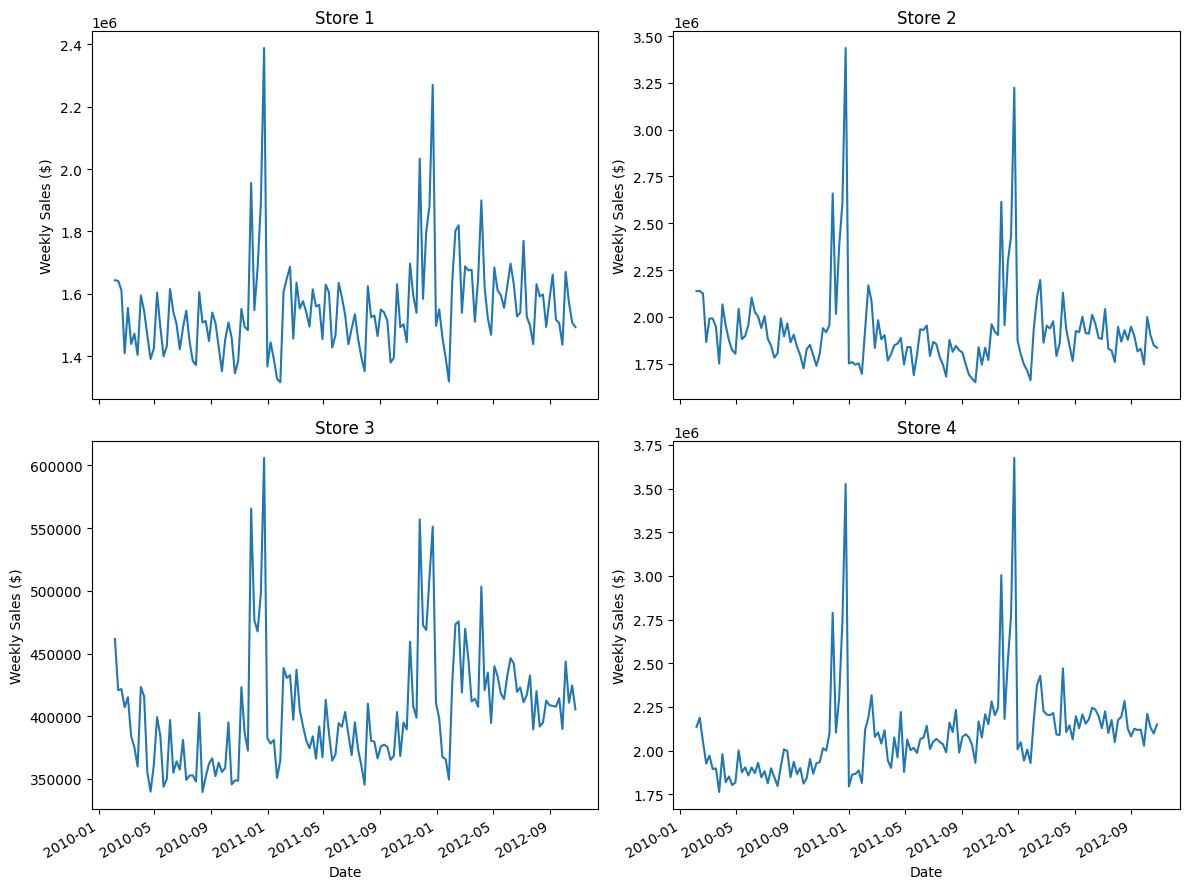

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['Store'] == i+1]

    ax.plot(plot_df['Date'], plot_df['Weekly_Sales'])
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

# TimeGPT

In [5]:
load_dotenv()
base_url = os.getenv("BASE_URL")
api_key = os.getenv("NIXTLA_API_KEY")

In [6]:
nixtla_client = NixtlaClient(
    base_url=base_url,
    api_key=api_key
)

## Zero-shot forecasting

In [7]:
preds = nixtla_client.forecast(
    df=df,
    h=8,
    id_col='Store',
    target_col='Weekly_Sales',
    time_col='Date',
    level=[80]
)
preds.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,Store,Date,TimeGPT,TimeGPT-hi-80,TimeGPT-lo-80
0,1,2012-11-02,1.557e+06,1.713e+06,1.400e+06
1,1,2012-11-09,1.569e+06,1.680e+06,1.457e+06
2,1,2012-11-16,1.576e+06,1.760e+06,1.393e+06
3,1,2012-11-23,1.602e+06,1.736e+06,1.469e+06
4,1,2012-11-30,1.606e+06,1.733e+06,1.478e+06


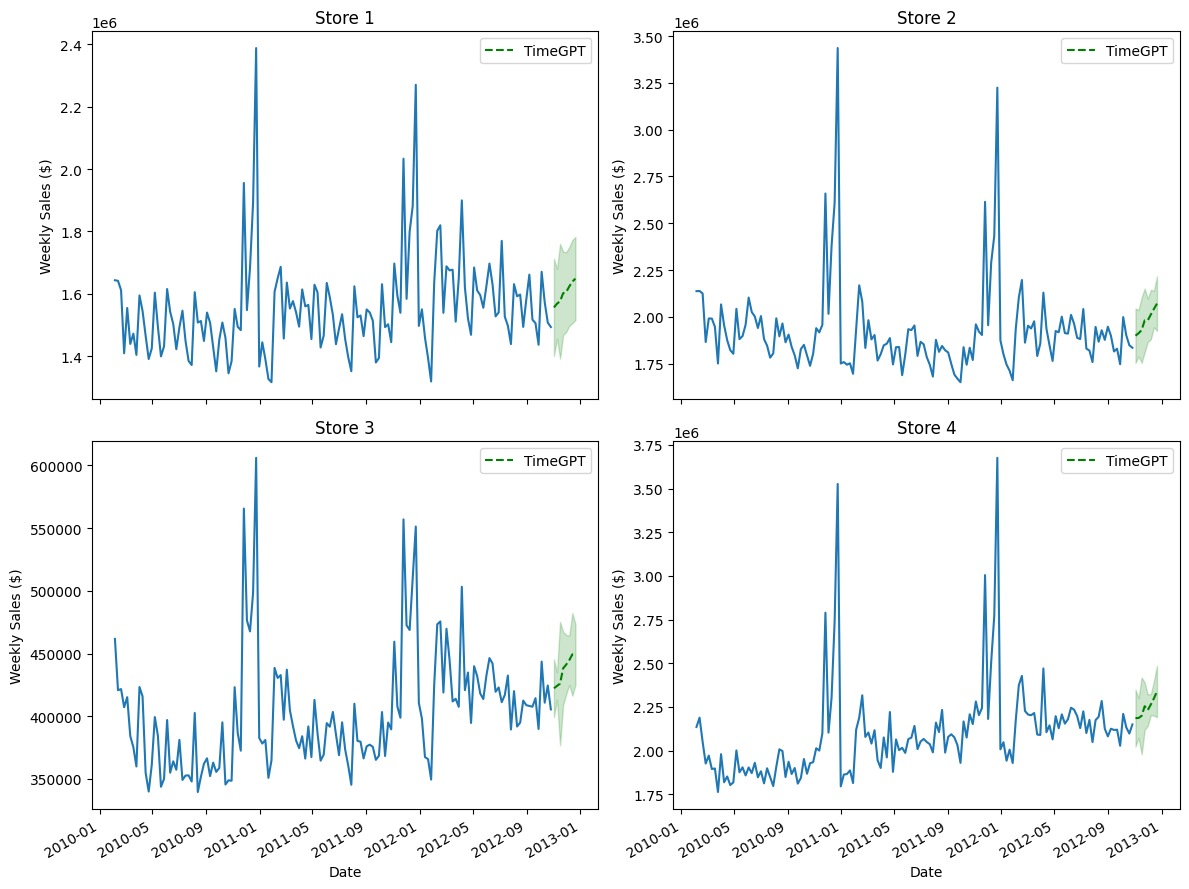

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['Store'] == i+1]
    plot_preds = preds[preds['Store'] == i+1]

    ax.plot(plot_df['Date'], plot_df['Weekly_Sales'])
    ax.plot(plot_preds['Date'], plot_preds['TimeGPT'], color='green', ls='--', label='TimeGPT')
    ax.fill_between(plot_preds['Date'], plot_preds['TimeGPT-hi-80'], plot_preds['TimeGPT-lo-80'], color='green', alpha=0.2)
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')
    ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Cross-validation

In [9]:
cv_df = nixtla_client.cross_validation(
    df=df,
    h=8,
    id_col='Store',
    target_col='Weekly_Sales',
    time_col='Date',
    level=[80],
    n_windows=4
)
cv_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
INFO:nixtla.nixtla_client:Calling Cross Validation Endpoint...


,Store,Date,cutoff,Weekly_Sales,TimeGPT,TimeGPT-hi-80,TimeGPT-lo-80
0,1,2012-03-23,2012-03-16,1.511e+06,1.619e+06,1.789e+06,1.448e+06
1,1,2012-03-30,2012-03-16,1.650e+06,1.634e+06,1.743e+06,1.524e+06
2,1,2012-04-06,2012-03-16,1.900e+06,1.644e+06,1.810e+06,1.477e+06
3,1,2012-04-13,2012-03-16,1.621e+06,1.677e+06,1.914e+06,1.441e+06
4,1,2012-04-20,2012-03-16,1.522e+06,1.667e+06,1.801e+06,1.532e+06


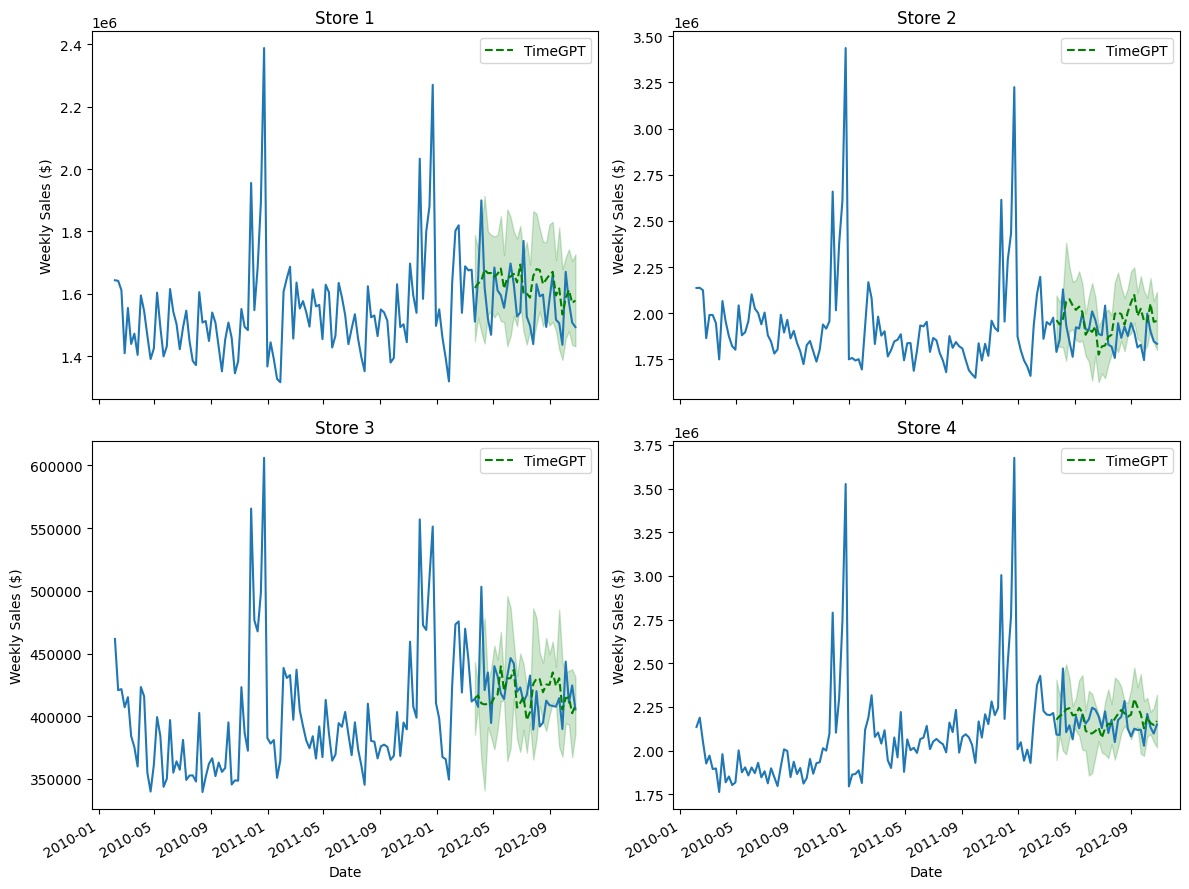

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    plot_df = df[df['Store'] == i+1]
    plot_cv = cv_df[cv_df['Store'] == i+1]

    ax.plot(plot_df['Date'], plot_df['Weekly_Sales'])
    ax.plot(plot_cv['Date'], plot_cv['TimeGPT'], color='green', ls='--', label='TimeGPT')
    ax.fill_between(plot_cv['Date'], plot_cv['TimeGPT-hi-80'], plot_cv['TimeGPT-lo-80'], color='green', alpha=0.2)
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')
    ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Fine-tuning

In [11]:
store1_df = df[df['Store'] == 1]

test_size = 32

train = store1_df[:-test_size]
test = store1_df[-test_size:]

print(len(train), len(test))

111 32


In [12]:
baseline_preds = nixtla_client.forecast(
    df=train,
    h=test_size,
    id_col='Store',
    time_col='Date',
    target_col='Weekly_Sales'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [13]:
longhorizon_preds = nixtla_client.forecast(
    df=train,
    h=test_size,
    id_col='Store',
    time_col='Date',
    target_col='Weekly_Sales',
    model='timegpt-1-long-horizon',
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [14]:
test = test.copy()
test = test[['Store', 'Date', 'Weekly_Sales']]
test.loc[:, 'TimeGPT'] = baseline_preds['TimeGPT'].values
test.loc[:, 'TimeGPT-long'] = longhorizon_preds['TimeGPT'].values
test.head()

,Store,Date,Weekly_Sales,TimeGPT,TimeGPT-long
111,1,2012-03-23,1.511e+06,1.665e+06,1.655e+06
112,1,2012-03-30,1.650e+06,1.655e+06,1.643e+06
113,1,2012-04-06,1.900e+06,1.663e+06,1.645e+06
114,1,2012-04-13,1.621e+06,1.652e+06,1.638e+06
115,1,2012-04-20,1.522e+06,1.648e+06,1.634e+06


In [15]:
evaluation = evaluate(
    df=test,
    metrics=[mae, smape],
    id_col='Store',
    time_col='Date',
    target_col='Weekly_Sales'
)
evaluation

,Store,metric,TimeGPT,TimeGPT-long
0,1,mae,91243.183,77186.207
1,1,smape,0.029,0.024


In [16]:
longhorizon_finetune_preds = nixtla_client.forecast(
    df=train,
    h=test_size,
    id_col='Store',
    time_col='Date',
    target_col='Weekly_Sales',
    model='timegpt-1-long-horizon',
    finetune_steps=10,
    finetune_loss='mae'
)
test.loc[:, 'TimeGPT-long-finetuned'] = longhorizon_finetune_preds['TimeGPT'].values

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [17]:
evaluation = evaluate(
    df=test,
    metrics=[mae, smape],
    id_col='Store',
    time_col='Date',
    target_col='Weekly_Sales'
)
evaluation

,Store,metric,TimeGPT,TimeGPT-long,TimeGPT-long-finetuned
0,1,mae,91243.183,77186.207,69502.470
1,1,smape,0.029,0.024,0.022


In [18]:
longhorizon_finetune_preds2 = nixtla_client.forecast(
    df=train,
    h=test_size,
    id_col='Store',
    time_col='Date',
    target_col='Weekly_Sales',
    model='timegpt-1-long-horizon',
    finetune_steps=10,
    finetune_loss='mae',
    finetune_depth=2,
)
test.loc[:, 'TimeGPT-long-finetuned2'] = longhorizon_finetune_preds2['TimeGPT'].values

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: W-FRI
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [19]:
evaluation = evaluate(
    df=test,
    metrics=[mae, smape],
    id_col='Store',
    time_col='Date',
    target_col='Weekly_Sales'
)
evaluation

,Store,metric,TimeGPT,TimeGPT-long,TimeGPT-long-finetuned,TimeGPT-long-finetuned2
0,1,mae,91243.183,77186.207,69502.470,67865.725
1,1,smape,0.029,0.024,0.022,0.021


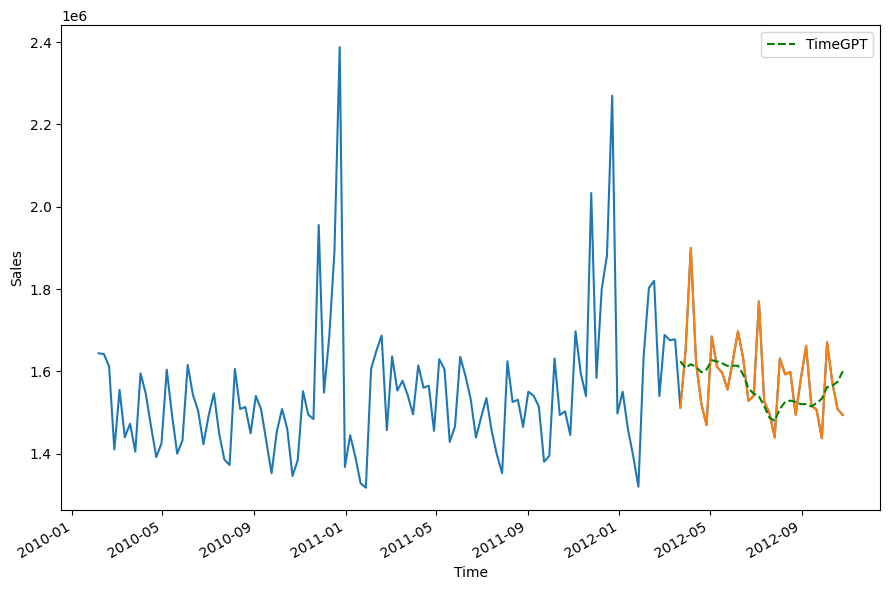

In [20]:
fig, ax = plt.subplots()

ax.plot(store1_df['Date'], store1_df['Weekly_Sales'])
ax.plot(test['Date'], test['Weekly_Sales'])
ax.plot(test['Date'], test['TimeGPT-long-finetuned2'], color='green', ls='--', label='TimeGPT')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

# Moirai

In [21]:
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [22]:
df = df[['Store', 'Date', 'Weekly_Sales']]
df = df.set_index('Date')
df.head()

,Store,Weekly_Sales
Date,,
2010-02-05,1,1.644e+06
2010-02-12,1,1.642e+06
2010-02-19,1,1.612e+06
2010-02-26,1,1.410e+06
2010-03-05,1,1.555e+06


In [23]:
ds = PandasDataset.from_long_dataframe(df, target='Weekly_Sales', item_id='Store')

INFO:gluonts.dataset.pandas:Grouping data by 'Store'; this may take some time.


In [24]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small"),
    prediction_length=8,
    context_length=len(df.query('Store == 1')),
    patch_size='auto',
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real
)

In [25]:
predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(ds)
forecasts = list(forecasts)

In [26]:
def get_median_and_ci(
    data, 
    start_date,
    horizon,
    freq,
    id,
    confidence=0.95
):    
    # Calculate the median for each timestep
    medians = np.median(data, axis=0)
    
    # Calculate the lower and upper percentile for the given confidence interval
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    
    # Calculate the lower and upper bounds for each timestep
    lower_bounds = np.percentile(data, lower_percentile, axis=0)
    upper_bounds = np.percentile(data, upper_percentile, axis=0)

    pred_dates = pd.date_range(start=start_date, periods=horizon, freq=freq)
    formatted_dates = pred_dates.strftime('%m-%d-%Y').tolist()
    
    # Create a DataFrame with the results
    df = pd.DataFrame({
        'Date': formatted_dates,
        'Store': id,
        'Moirai': medians,
        f'Moirai-lo-{int(confidence*100)}': lower_bounds,
        f'Moirai-hi-{int(confidence*100)}': upper_bounds
    })
    
    return df

In [27]:
preds = [
    get_median_and_ci(
        data=forecasts[i].samples,
        start_date='11-02-2012',
        horizon=8,
        freq='W-FRI',
        id=i+1,
        confidence=0.80
    )
    for i in range(4)
]

preds_df = pd.concat(preds, axis=0, ignore_index=True)
preds_df['Date'] = pd.to_datetime(preds_df['Date'])

preds_df.head()

,Date,Store,Moirai,Moirai-lo-80,Moirai-hi-80
0,2012-11-02,1,1.536e+06,1.446e+06,1.663e+06
1,2012-11-09,1,1.533e+06,1.415e+06,1.618e+06
2,2012-11-16,1,1.538e+06,1.463e+06,1.666e+06
3,2012-11-23,1,1.532e+06,1.403e+06,1.667e+06
4,2012-11-30,1,1.540e+06,1.388e+06,1.702e+06


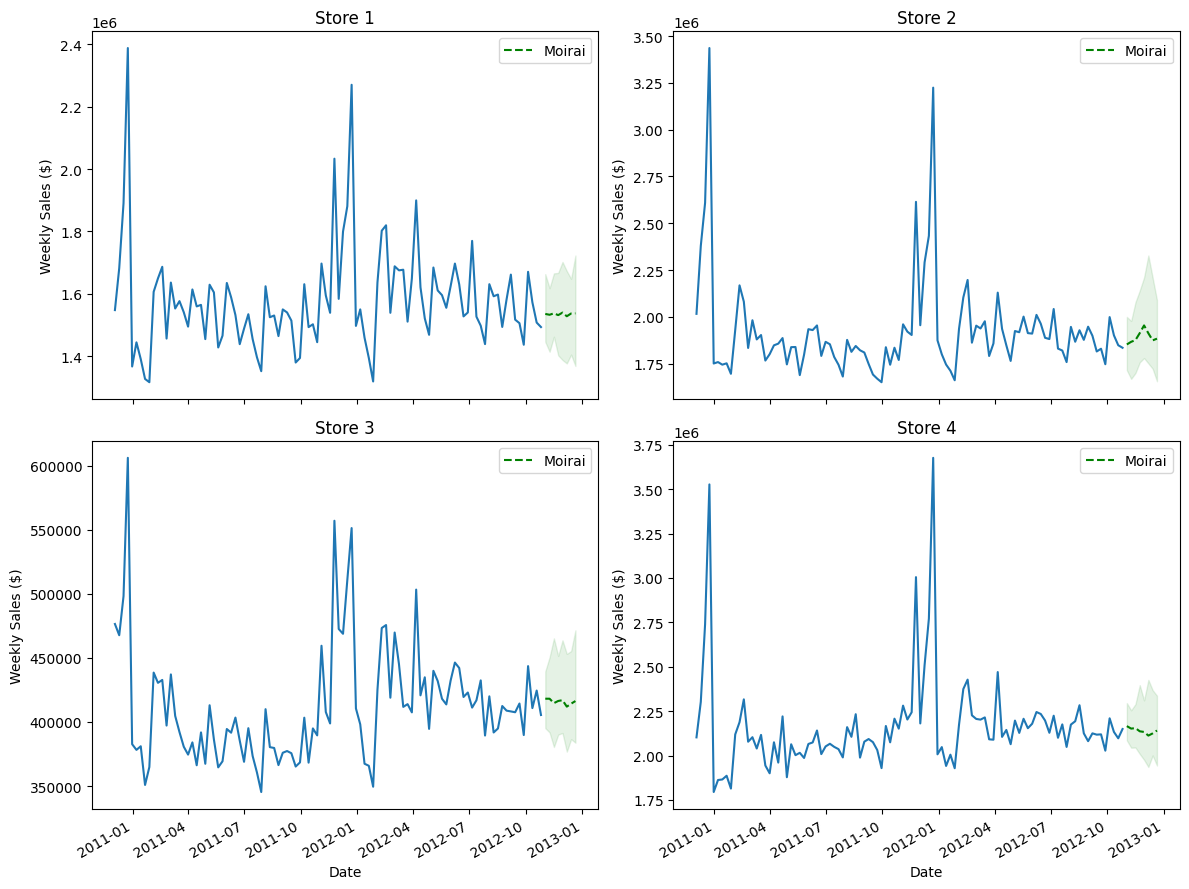

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

plot_df = df.reset_index(drop=False).copy()
plot_preds_df = preds_df.copy()

for i, ax in enumerate(axes.flatten()):
    df = plot_df[plot_df['Store'] == i+1].iloc[-100:]
    preds_df = plot_preds_df[plot_preds_df['Store'] == i+1]

    ax.plot(df['Date'], df['Weekly_Sales'])
    ax.plot(preds_df['Date'], preds_df['Moirai'], 'g--', label='Moirai')
    ax.fill_between(preds_df['Date'], preds_df['Moirai-lo-80'], preds_df['Moirai-hi-80'], alpha=0.1, color='green')
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

## Evaluate Moirai

In [29]:
df = pd.read_csv(url, parse_dates=["Date"])
df = df[['Store', 'Date', 'Weekly_Sales']]
df = df[df['Store'] == 1]
df_train = df[:-32]
df_train = df.set_index('Date')
ds = PandasDataset.from_long_dataframe(df_train, target='Weekly_Sales', item_id='Store')

INFO:gluonts.dataset.pandas:Grouping data by 'Store'; this may take some time.


In [30]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained("Salesforce/moirai-1.0-R-small"),
    prediction_length=32,
    context_length=111,
    patch_size='auto',
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real
)

In [31]:
predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(ds)
forecasts = list(forecasts)

In [32]:
moirai_preds = get_median_and_ci(
    data=forecasts[0].samples,
    start_date='03-23-2012',
    horizon=32,
    freq='W-FRI',
    id=1,
    confidence=0.80
)
moirai_preds.head()

,Date,Store,Moirai,Moirai-lo-80,Moirai-hi-80
0,03-23-2012,1,1.573e+06,1.516e+06,1.634e+06
1,03-30-2012,1,1.569e+06,1.516e+06,1.653e+06
2,04-06-2012,1,1.569e+06,1.498e+06,1.634e+06
3,04-13-2012,1,1.559e+06,1.489e+06,1.641e+06
4,04-20-2012,1,1.555e+06,1.496e+06,1.635e+06


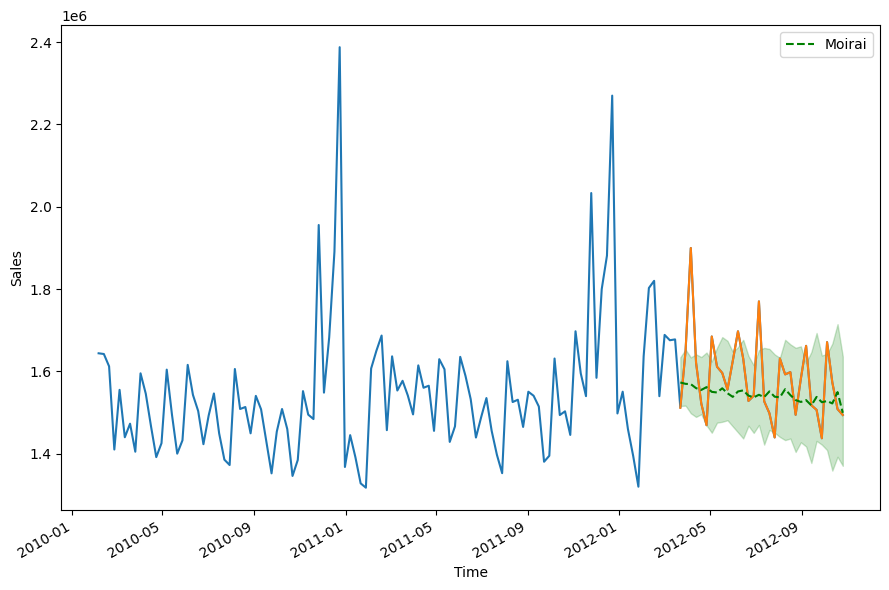

In [33]:
fig, ax = plt.subplots()

ax.plot(store1_df['Date'], store1_df['Weekly_Sales'])
ax.plot(test['Date'], test['Weekly_Sales'])
ax.plot(test['Date'], moirai_preds['Moirai'], color='green', ls='--', label='Moirai')
ax.fill_between(test['Date'], moirai_preds['Moirai-lo-80'], moirai_preds['Moirai-hi-80'], color='green', alpha=0.2)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [34]:
test.loc[:, 'Moirai'] = moirai_preds['Moirai'].values
evaluation = evaluate(
    df=test,
    metrics=[mae, smape],
    id_col='Store',
    time_col='Date',
    target_col='Weekly_Sales'
)
evaluation

,Store,metric,TimeGPT,TimeGPT-long,TimeGPT-long-finetuned,TimeGPT-long-finetuned2,Moirai
0,1,mae,91243.183,77186.207,69502.470,67865.725,74732.413
1,1,smape,0.029,0.024,0.022,0.021,0.023


# Chronos

In [36]:
from chronos import BaseChronosPipeline

In [37]:
df = pd.read_csv(url, parse_dates=["Date"])

In [38]:
context = [torch.tensor(df.query("Store == @i")['Weekly_Sales'].to_numpy()) for i in range(1, 5)]

In [39]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-small",
    device_map="cpu",  # use "cuda" for GPU inference
    torch_dtype=torch.bfloat16,
)

In [40]:
quantiles, mean = pipeline.predict_quantiles(
    context=context,
    prediction_length=8,
    quantile_levels=[0.1, 0.5, 0.9],
)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


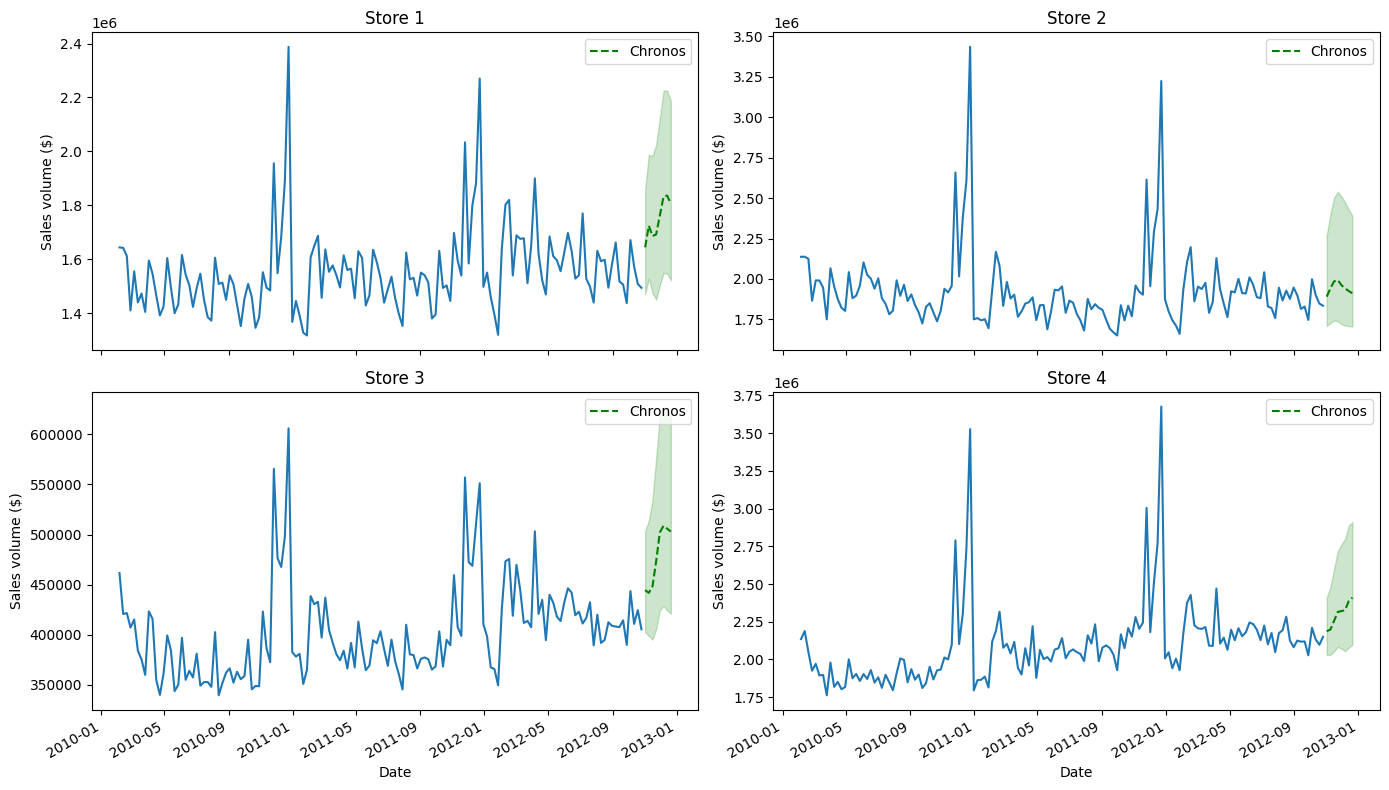

In [46]:
start_date = pd.to_datetime('2012-10-26')
forecast_dates =  [start_date + pd.DateOffset(weeks=i) for i in range(1, 9)]
preds = mean.numpy()
quantiles = quantiles.numpy()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,8))

for i, ax in enumerate(axes.flatten()):
    store_id = i+1
    data = df.query("Store == @store_id")

    ax.plot(data['Date'], data['Weekly_Sales'])
    ax.plot(forecast_dates, preds[i], ls='--', color='green', label='Chronos')
    ax.fill_between(forecast_dates, quantiles[i, :, 0], quantiles[i, :, 2], color="green", alpha=0.2)
    
    ax.set_title(f"Store {store_id}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales volume ($)')
    ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()

## Evaluate Chronos

In [47]:
df = df[df['Store'] == 1]
train_df = df[:-32]

111


In [48]:
context = torch.tensor(train_df['Weekly_Sales'])

In [49]:
quantiles, mean = pipeline.predict_quantiles(
    context=context,
    prediction_length=32,
    quantile_levels=[0.1, 0.5, 0.9],
)

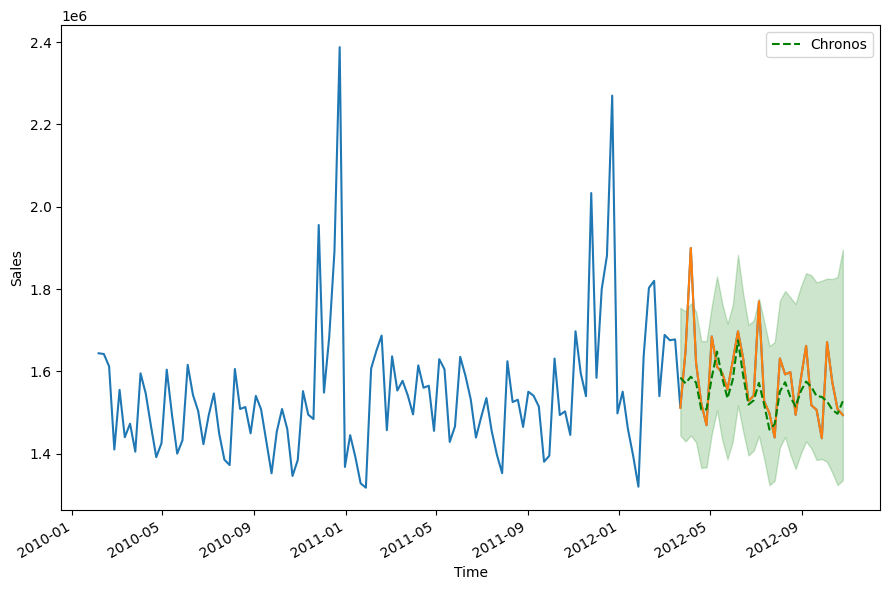

In [54]:
quantiles = quantiles.numpy()
fig, ax = plt.subplots()

ax.plot(store1_df['Date'], store1_df['Weekly_Sales'])
ax.plot(test['Date'], test['Weekly_Sales'])
ax.plot(test['Date'], mean.numpy()[0], ls='--', color='green', label='Chronos')
ax.fill_between(test['Date'], quantiles[0, :, 0], quantiles[0, :, 2], color='green', alpha=0.2)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [55]:
test.loc[:, 'Chronos'] = mean.numpy()[0]
evaluation = evaluate(
    df=test,
    metrics=[mae, smape],
    id_col='Store',
    time_col='Date',
    target_col='Weekly_Sales'
)
evaluation

,Store,metric,TimeGPT,TimeGPT-long,TimeGPT-long-finetuned,TimeGPT-long-finetuned2,Moirai,Chornos
0,1,mae,91243.183,77186.207,69502.470,67865.725,74732.413,58607.722
1,1,smape,0.029,0.024,0.022,0.021,0.023,0.018
